In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.time_frequency import tfr_morlet
from mne.io import read_raw_edf


In [2]:
# Path to your EDF file
edf_file_path = 'subject_1_fvep_led_training_1.edf'

# Load the EDF file
raw = read_raw_edf(edf_file_path, preload=True)
# Print information about all channels
# print(raw.info['chs'])

# Or for a more readable format
print(raw.info)

Extracting EDF parameters from /Users/pellet/dev/brainhack/ssvep_analysis/subject_1_fvep_led_training_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 57855  =      0.000 ...   225.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 11
 projs: []
 sfreq: 256.0 Hz
 subject_info: 4 items (dict)
>


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


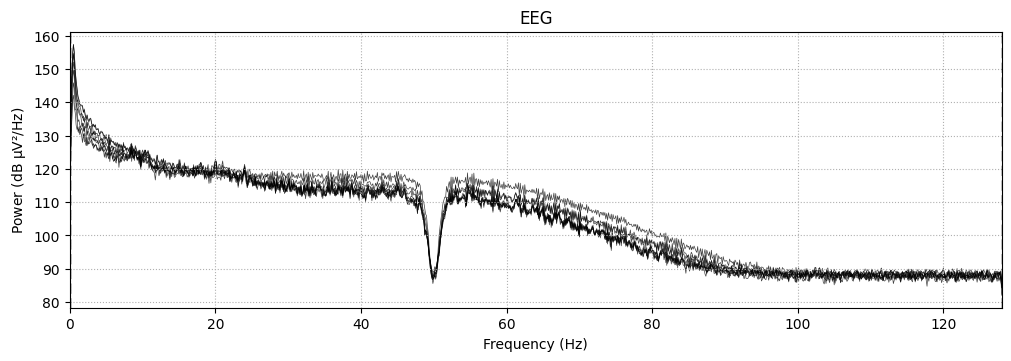

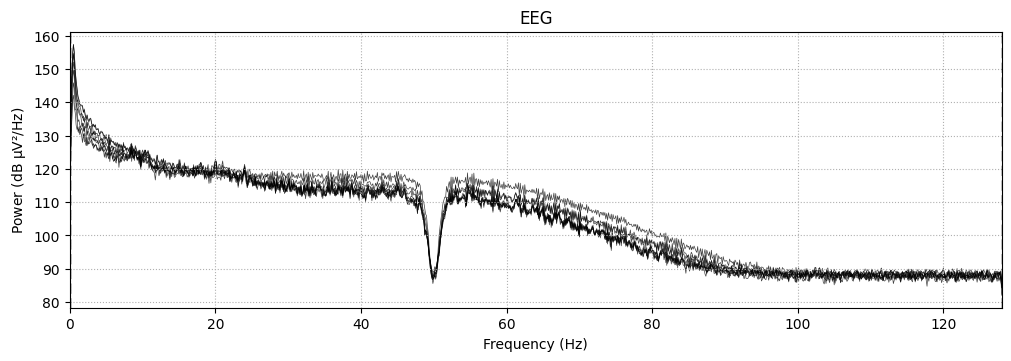

In [3]:
print(raw.ch_names)
picks = [1,2,3,4,5,6,7,8]

# Plot each channel individually with its number in the title
# fig, axes = plt.subplots(len(picks), 1, figsize=(10, 2*len(picks)), sharex=True)

# Compute PSD once
psd = raw.compute_psd(picks=picks)
psd.plot()

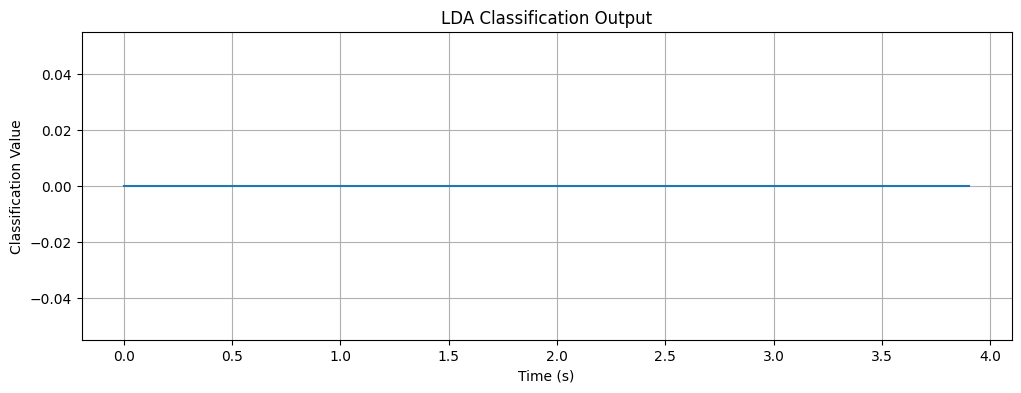

Unique classification values: [0. 3.]
Class 0.0: 51200 samples (88.50%)
Class 3.0: 6656 samples (11.50%)


In [4]:

# Extract the data from the identified channel
lda_output, times = raw['11', :]
lda_output = lda_output.flatten()  # Convert to 1D array

# Plot the LDA classification output
plt.figure(figsize=(12, 4))
plt.plot(times[:1000], lda_output[:1000])  # Plot first 1000 samples
plt.title('LDA Classification Output')
plt.xlabel('Time (s)')
plt.ylabel('Classification Value')
plt.grid(True)
plt.show()

# Analyze the classification values
unique_values = np.unique(lda_output)
print(f"Unique classification values: {unique_values}")

# If the LDA output represents class labels (e.g., 1, 2, 3, 4 for different frequencies)
# you can count occurrences of each class
if len(unique_values) < 10:  # Assuming it's a small set of discrete classes
    for val in unique_values:
        count = np.sum(lda_output == val)
        percentage = (count / len(lda_output)) * 100
        print(f"Class {val}: {count} samples ({percentage:.2f}%)")


## Epoching



In [5]:
# Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus.
# Note: we will not reject epochs here because the amplitude of the SSVEP at POz is so large it is difficult to separate from eye blinks

# events = find_events(raw, stim_channel='10')
events = find_events(raw, stim_channel='11')
events

# Method 1: Show unique event IDs
unique_event_ids = np.unique(events[:, 2])
print("Unique event IDs:", unique_event_ids)


# event_id = {'off': 0, 'on': 1}
# event_id = {'on': 1}
event_id = {'on': 3, 'off': 0}
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.5, tmax=4, baseline=None, preload=True,
                verbose=False, picks=picks)
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

13 events found on stim channel 11
Event IDs: [3]
Unique event IDs: [3]


ValueError: No matching events found for off (event id 0)

## Stimuli-Specific PSD



In [ ]:
print(epochs.ch_names)

welch_params=dict(method='welch',
                  n_fft=1028,
                  n_per_seg=256 * 3,
                  picks='all')

psd1, freq1 = epochs['on'].compute_psd(**welch_params).get_data(return_freqs=True)
psd1 = 10 * np.log10(psd1)

psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)
print(psd1_mean.shape)
for i, ch_name in enumerate(epochs.ch_names):
    f, axs = plt.subplots(1, 1, figsize=(10, 5))

    axs.plot(freq1, psd1_mean[[i], :].mean(0), color='b', label='on')

    axs.set_title(f'channel {i}')

    axs.set_ylabel('Power Spectral Density (dB)')

    axs.set_xlim((2, 20))

    axs.set_xlabel('Frequency (Hz)')

    axs.legend()

    plt.show()


## Spectrogram



In [ ]:
frequencies = np.logspace(1, 1.75, 60)
tfr, itc = tfr_morlet(epochs['on'], freqs=frequencies,picks='all',
                              n_cycles=15, return_itc=True)
tfr.plot(picks=[1], baseline=(-0.5, -0.1), mode='logratio',
                 title='Oz - all stim');
tfr.plot(picks=[0], baseline=(-0.5, -0.1), mode='logratio',
                 title='PO7 - all stim');
tfr.plot(picks=[2], baseline=(-0.5, -0.1), mode='logratio',
                 title='PO8 - all stim');